# US Accounting Dataset - Regression Analysis

We'll begin by importing the modules needed for our Regression algorithms, as well as the standard modules for data manipulation and visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import operator
from regression_funcs import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.graphics.factorplots import interaction_plot

%matplotlib inline

In [2]:
def press_statistic(y_true, y_pred, xs):
    """
    Calculation of the `Press Statistics <https://www.otexts.org/1580>`_
    """
    res = y_pred - y_true
    hat = xs.dot(np.linalg.pinv(xs))
    den = (1 - np.diagonal(hat))
    sqr = np.square(res/den)
    return sqr.sum()

def predicted_r2(y_true, y_pred, xs):
    """
    Calculation of the `Predicted R-squared <https://rpubs.com/RatherBit/102428>`_
    """
    press = press_statistic(y_true=y_true,
                            y_pred=y_pred,
                            xs=xs
    )

    sst  = np.square( y_true - y_true.mean() ).sum()
    return 1 - press / sst
 
def get_r2(y_true, y_pred):
    """
    Calculation of the unadjusted r-squared, goodness of fit metric
    """
    sse  = np.square( y_pred - y_true ).sum()
    sst  = np.square( y_true - y_true.mean() ).sum()
    return 1 - sse/sst

Then we'll load our cleaned accounting data into a DataFrame

In [3]:
us_accounting = pd.read_csv('./us_accounting_clean.csv',)

# Regression
Let's start with a heatmap of the correlation between our quantitative variables to see what correlations exist that could be used for regression.

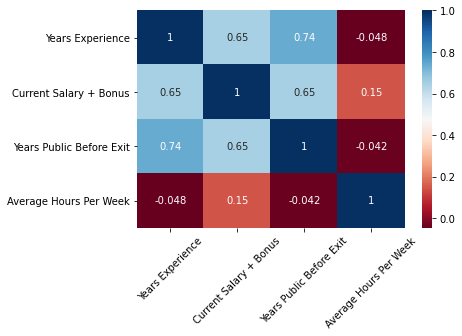

Counts for quantitative variables:
________________________________________
Years Experience            1196.0
Current Salary + Bonus      1196.0
Years Public Before Exit     216.0
Average Hours Per Week       648.0
Name: count, dtype: float64



In [4]:
sns.heatmap(us_accounting.corr(), annot=True, cmap='RdBu')
plt.xticks(rotation=45)
plt.show()

print('Counts for quantitative variables:')
print('_' * 40)
print(us_accounting.describe().loc['count'])
print()

According to the heatmap and correlation matrix, `Current Salary + Bonus` is most closely correlated with `Years Public Before Exit` and `Years Experience`, having almost exactly the same correlation coefficients with each.  Remember though, `Years Public Before Exit` only applies to 216 accountants in the dataset, those who exited a public firm and now work in a private firm, whereas `Years Experience` applies to all 1196 of our accountants, as can be seen in the counts above.  For the accountants where both of the variables apply, in many cases the `Years Public Before Exit` value will be similar to the `Years Experience` value and will contribute similar information to the analysis.  In these circumstances, using both in an analysis may be redundant.  

Because the heatmap shows there aren't any other pairs of variables with significant correlation that might be worth investigating, it seems like the best variable for predicting `Current Salary + Bonus` should be `Years Experience`.  `Years Experience` has the highest correlation and let's us use the data for all 1196 of our accountants so we'll begin there.

## Univariate Linear Regression  - `Predicting Current Salary + Bonus` using `Years Experience`

Would linear regression be a good model?  How good would it be at making these predictions?


### All Accountants
We'll start with a regression on all 1196 accountants in the survey and check the model's performance using residuals and Root Mean Squared Error (RMSE):

RMSE: 35971.11322977221


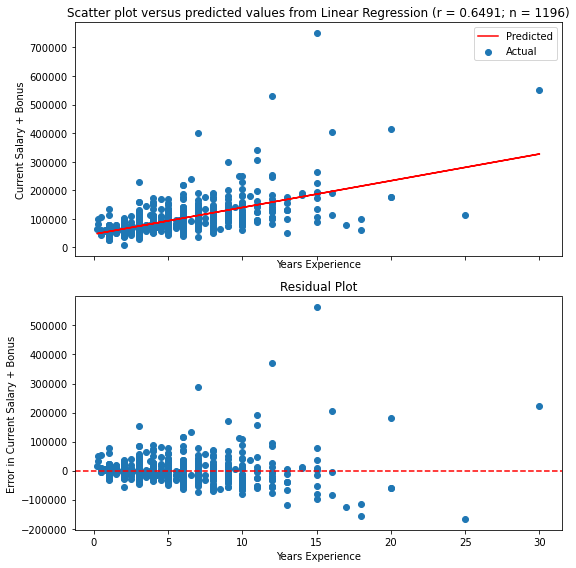

In [5]:
model, preds, residuals, rmse = create_scipy_linear_model(us_accounting, 'Years Experience', 'Current Salary + Bonus', plot=True)
print('RMSE: {}'.format(rmse))

The residual plot looks ok...it generally looks like there's an even distribution of points above and below a residual of 0 for most of the plot with two exceptions: Around 0 years experience, and past 12 or 13 years experience, with more than 15 years experience having a strong tendency to underestimate.  
* The issue above 15 years experience makes sense as there are very few accountants in our survey below with that much experience and regression will have a harder time with predictions here.  These accountants also tend to have the highest salaries in the dataset and are outliers, further compounding the issue with regression
* The issue around 0 years experience is a little harder to address, but if we look at those accountants in the survey, there are a few discrepancies.  For instance there is one person who says they are still in school and earn 100000 annually, with their line of service being intern.  That entry seems questionable I'm going to drop it.  Also, that one guy in finance who's making 105,000 annually but has 0.5 years experience.  That one might be ok, but the salary seems high for the experience level.  Not sure if that observation is valid and it may need to be deleted.  There may be other questionable entries as well, I need to come back and do more investgation and perhaps cleaning here.

In [6]:
#us_accounting[us_accounting['Years Experience'] < 1]

In [7]:
us_accounting.drop(6, inplace=True)

In [8]:
#us_accounting[us_accounting['Years Experience'] > 15]

In [9]:
#us_accounting[(us_accounting['Years Experience'] <= 15) & (us_accounting['Years Experience'] > 10)]

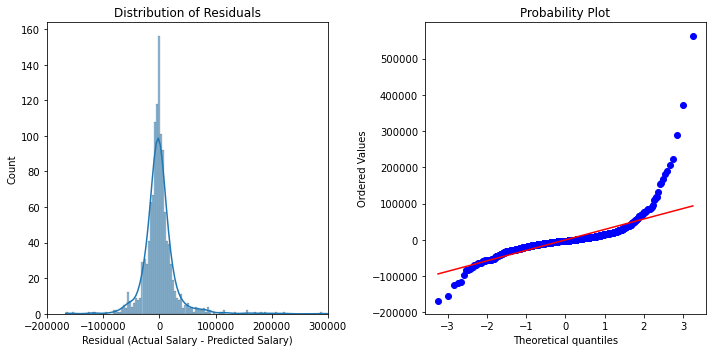

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

sns.histplot(residuals, kde=True, ax=ax[0])
ax[0].set_xlim(-200_000, 300_001)
ax[0].set_title('Distribution of Residuals')
ax[0].set_xlabel('Residual (Actual Salary - Predicted Salary)')

scipy.stats.probplot(residuals, plot = ax[1])

plt.tight_layout()
plt.show()

On the surface, the distribution of residuals looks as if it's approximately normally distributed, however checking the probability plot to the right, we see problems in both of the tails, with an especially fat right tail and the assumption of normality of error terms is violated with this model.

Since the other assumptions of linear regression were ok, perhaps we can do some tinkering and create a new model that would have normal error terms.  As this is our first model, we'll use its RMSE of ~36,000 and R-Value of 0.6491 to compare performance against the next model we create.

### Regression for Accountants with 15 years experience or less

Earlier, we noticed that our residual plot tended to underestimate salaries for accountants who had more than 15 years experience.  This could also address the problem with the tails in our probability plot.  One way to deal with this would be to drop those accountants and run the regression again, which I think would be reasonable given the following assumption:

**Assumption: Most people using this model for predictions will likely want to predict their salaries for an interval of time similar to 0-15 years: what one would make at an entry level position (0-5 years), middle level position (5-10 years), or senior level position(10-15 years)).**

If the above is true and our model is primarily going to be used by accountants with 0-15 years of experience, let's see how well it performs against the linear regression model we created earlier using all of our accountants. 

In [11]:
yrs_exp_under_15 = us_accounting[us_accounting['Years Experience'] <= 15].copy(deep=True)

RMSE - Accountants with 15 years experience or less: 33448.96


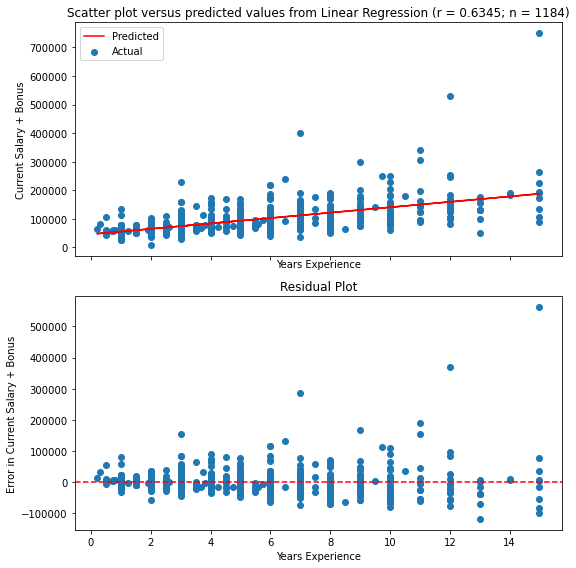

In [12]:
model, preds, residuals, rmse = create_scipy_linear_model(yrs_exp_under_15, 'Years Experience', 'Current Salary + Bonus', plot=True)
print('RMSE - Accountants with 15 years experience or less: {:.2f}'.format(rmse))

By focusing on accountants with 15 years of experience or less, we've only cut out 11 accountants and still have the vast majority of data to use in the prediction.  The drawback is that our model is no longer valid for any accountant, it's only valid for those with 15 years of experience or less, however if our assumption is correct, this shouldn't be an issue.  

The residual plot still looks a little unbalanced around 0 years experience and also at around 13 or 14 years, but nothing too bad.

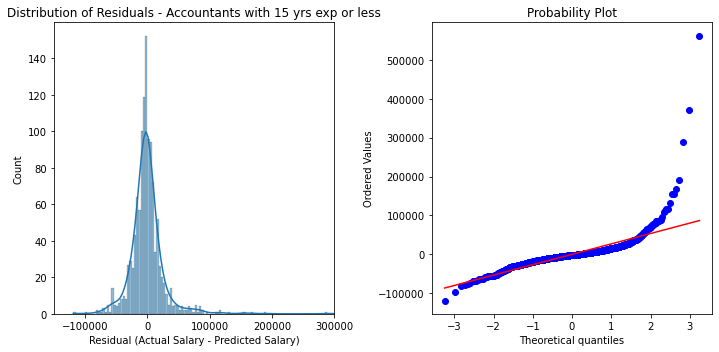

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

sns.histplot(residuals, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Residuals - Accountants with 15 yrs exp or less')
ax[0].set_xlabel('Residual (Actual Salary - Predicted Salary)')
ax[0].set_xlim(-150_000, 300_001)

scipy.stats.probplot(residuals, plot = ax[1])

plt.tight_layout()
plt.show()

The distribution of residuals still looks approximately normally distributed and the probability plot no longer has an issue with the left tail, but now is looks skewed right and we still have that fat tail to deal with.  I suspect this may be due to the salaries that are outliers.

The RMSE has decreased slightly, now about 33,500, compared to the RMSE of 36,000 earlier and the R-value has decreased slightly, now at 0.6336 compared to 0.6491 from earlier.  Our new model is a little better in performance, but the assumption of error terms that are normally distributed is still violated and perhaps we can do more tinkering.  We'll make a new model and use these new numbers, RMSE: 33,500 and R-value: 0.6336, for comparison.

### Regression for accountants with 15 years experience or less and non-outlier salaries
I will isolate outliers that are higher than 1.5 * IQR from the third quartile (Q3), then create a new linear regression model and check our assumptions and its performance again.

In [14]:
yrs_exp_describe = yrs_exp_under_15['Current Salary + Bonus'].describe()
IQR = yrs_exp_describe['75%'] - yrs_exp_describe['25%']
lower_fence_salary = yrs_exp_describe['25%'] - 1.5 * IQR
upper_fence_salary = yrs_exp_describe['75%'] + 1.5 * IQR
yrs_exp_without_outliers = yrs_exp_under_15[(yrs_exp_under_15['Current Salary + Bonus'] >= lower_fence_salary) & (yrs_exp_under_15['Current Salary + Bonus'] <= upper_fence_salary)].copy(deep=True)

RMSE - Only accountants with 15 years experience or less and accountants with non-outlier salaries: 17296.71


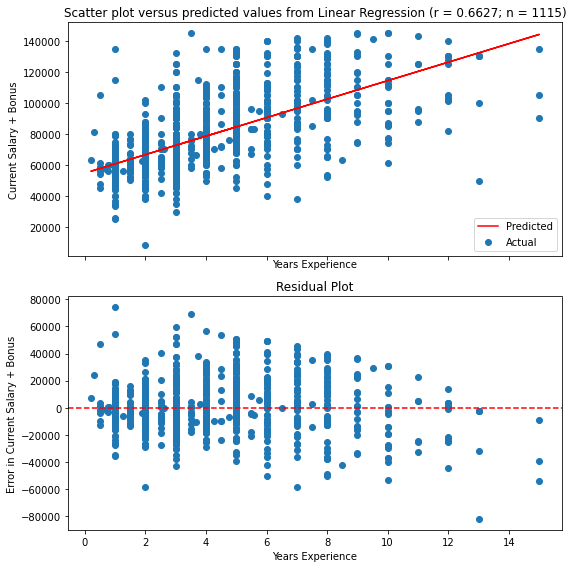

In [15]:
model, preds, residuals, rmse = create_scipy_linear_model(yrs_exp_without_outliers, 'Years Experience', 'Current Salary + Bonus', plot=True)
print('RMSE - Only accountants with 15 years experience or less and accountants with non-outlier salaries: {:.2f}'.format(rmse))

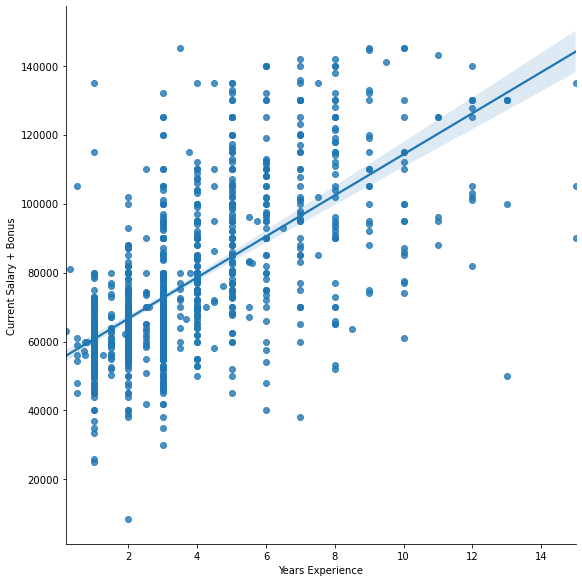

In [16]:
sns.lmplot(x='Years Experience', y='Current Salary + Bonus', data=yrs_exp_without_outliers, palette='pastel', height=8)

Our sample size has dropped to 1115, but is still more than sizeable enough for our analysis, and while the residual plot remains a bit unbalanced around 0 years and 13 or 14 years, overall the residuals look pretty reasonable.

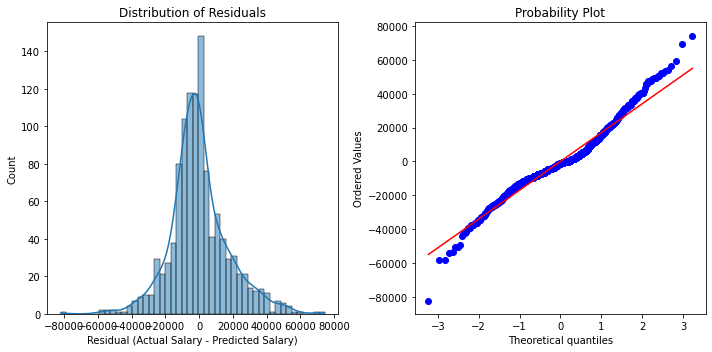

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

sns.histplot(residuals, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Residuals')
ax[0].set_xlabel('Residual (Actual Salary - Predicted Salary)')

scipy.stats.probplot(residuals, plot = ax[1])

plt.tight_layout()
plt.show()

The distribution of residuals looks approximately normal and the probability plot no longer looks skewed right. The tails are a little fatter than desirable and the error terms may not quite be normally distributed yet.  

RMSE has dropped significantly to about half of what it used to be, now at ~17,000 and the R-value has increased to 0.6627.  This model has the best performance so far and is closest to satisfying the assumptions needed for linear regression.  I think we're close to a good model and I plan to apply a log transformation to the salaries and create a new model which is hopefully better.  

### Lognormal transformation

We'll handle outliers in the tails by applying a log10 transformation to the salaries and then checking the performance and residuals of the new model.

RMSE: 18016.296896515047


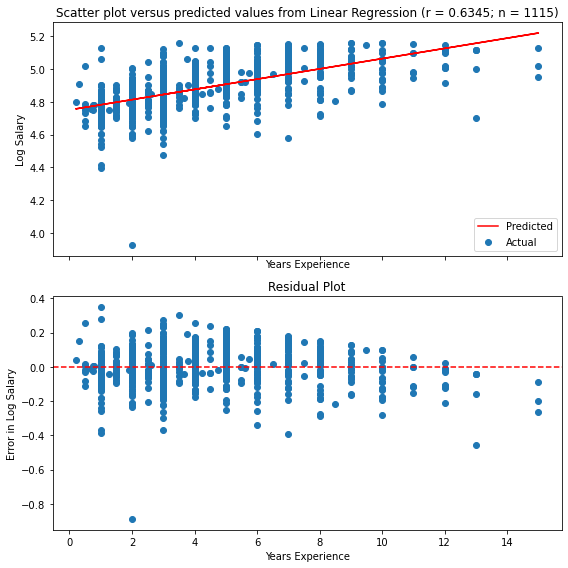

In [18]:
yrs_exp_without_outliers['Log Salary'] = np.log10(yrs_exp_without_outliers['Current Salary + Bonus'])

model, preds, residuals, rmse = create_scipy_linear_model(yrs_exp_without_outliers, 'Years Experience', 'Log Salary', plot=True)

rmse = np.sqrt(mean_squared_error(yrs_exp_without_outliers['Current Salary + Bonus'], 10**preds))
print("RMSE: {}".format(rmse))

Nothing too different in the residual plots, but...

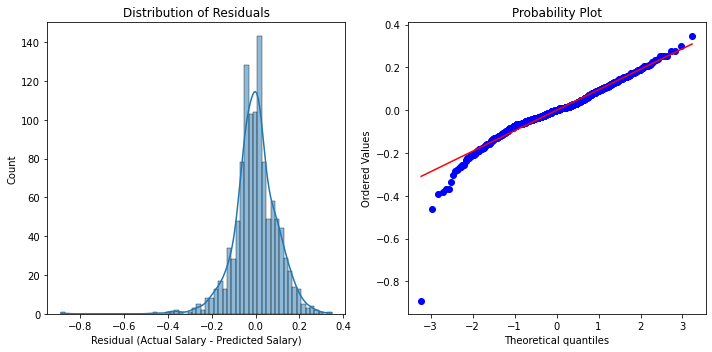

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

sns.histplot(residuals, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Residuals')
ax[0].set_xlabel('Residual (Actual Salary - Predicted Salary)')

scipy.stats.probplot(residuals, plot = ax[1])

plt.tight_layout()
plt.show()

The error terms are looking much better now!  We see a bit of left skew, but the probability plot indicates the error terms are close to normal.  Furthermore, the performance of this model is similar to the last.  The RMSE is a little worse at ~18,000, and the R-Value has decreased slightly to 0.6345.

For now, I think the assumptions are close enough to being met and I plan to move on.

## Verifying results with `train_test_split` - After discovering this relationship, how well does this model generalize to our data?

### Confidence interval for log transformed salaries of accountants with 15 years of experience or less, excluding salaries more than 1.5 * IQR above Q3.

Let's create a train/test split, train a linear regression model, and verify its performance on a test set, comparing against the RMSE of ~18,000 and R-value of 0.6345 we observed from the last linear regression model created.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(yrs_exp_without_outliers['Years Experience'], yrs_exp_without_outliers['Log Salary'], test_size=0.3, random_state=115)

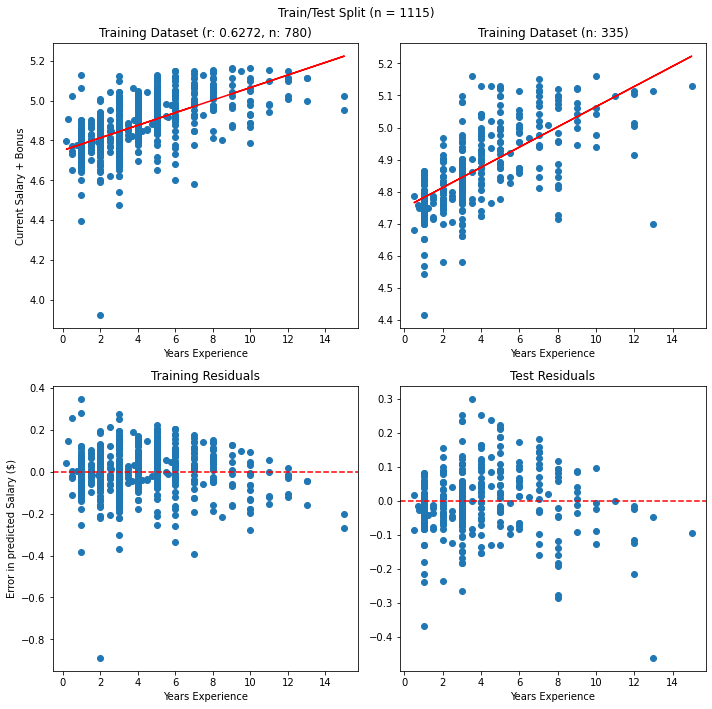

Testing Data - RMSE: 18989.65
Testing Data - R-Value: 0.6148


In [21]:
model, preds, residuals, test_rmse, test_r_val = create_train_test_scipy_model(yrs_exp_without_outliers, 'Years Experience', 'Log Salary', plot=True, log=True, random_state=115)
print("Testing Data - RMSE: {:.2f}".format(test_rmse))
print("Testing Data - R-Value: {:.4f}".format(test_r_val))

Our RMSE and R-Value for the model that was trained on the log transformed salaries was ~18,000 and 0.6324 respectively.  Verifying against our testing set, we have RMSE 19,000, with an R-value of 0.6148.  The difference in RMSE is minimal and while the R-value has decreased slightly, it's nothing significant.  These results indicate that our model generalizes well and linear regression continues to look like a good model for our predictions.

Because the train/test split was generated by a random process, this similar performance might just be caused by chance, and while this model looks like it generalizes well, perhaps a different model generated from a different train/test split wouldn't generalize as well. To get a sense for what the model will perform like most of the time, we can check with a confidence interval.

#### Confidence interval for RMSE/R-Value for log transformed salaries:
Let's simulate 1,000 different train/test splits and compute a 95% confidence interval for RMSE and the R-Value.

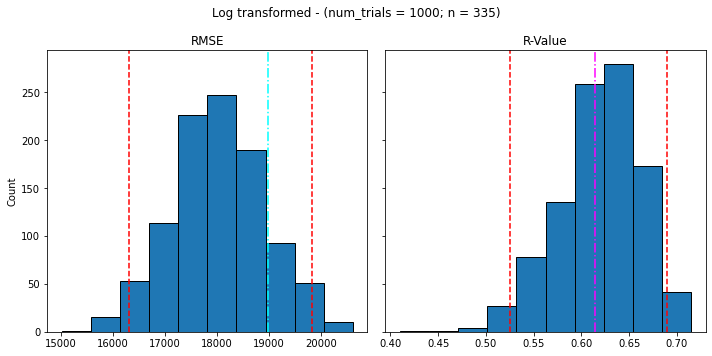

Test RMSE 95.0% Confidence Interval for 1000 trials: (16304.34, 19833.68)
Test R-Value 95.0% Confidence Interval for 1000 trials: (0.5257, 0.6898)


In [22]:
num_trials = 1_000
c_level = 0.95

rmse_left, rmse_right, r_val_left, r_val_right = create_conf_ints(yrs_exp_without_outliers, 'Years Experience', 'Log Salary', num_trials, test_rmse, test_r_val, c_level, log=True, plot=True)
print('Test RMSE {}% Confidence Interval for {} trials: ({:.2f}, {:.2f})'.format(c_level*100, num_trials, rmse_left, rmse_right))
print('Test R-Value {}% Confidence Interval for {} trials: ({:.4f}, {:.4f})'.format(c_level*100, num_trials, r_val_left, r_val_right))

The confidence intervals above indicate that our RMSE for a model fitted by randomly generating a train/test split, will be between roughly 16,000 and 20,000, most of the time, an error of about +/- 2,000.  Furthermore, our observed Test RMSE of 19,000 from the train/test split model earlier, pictured above in cyan, looks like a typical value, being just a bit right of the center.

The confidence interval for the Test R-Value is a little wide, falling between 0.52 and 0.69, with a margin of error of roughly +/- 0.09.  Furtheremore, our observed Test R-value from the train/test split model earlier, picture above in fuchsia, is a typical value lying just a bit lower than center.

It appears that our model generalizes well and performs decently when used to make predictions on testing data.

**Conclusion: Linear Regression using `Years Experience` to predict `Current Salary + Bonus` generalizes well to testing data, offers decent predictions, and is easy to implement.**

**We will consider this linear model as our baseline model for future comparisons**

#### Linear Regression done!

## Univariate Polynomial Regression - `Years Experience` vs `Current Salary + Bonus` 

Can Polynomial Regression yield better results as compared to linear regression?  I didn't see any signs of curvature in the scatter plots earlier and I think it's unlikely that polynomial regression will bring much improvement, but we can try.

### All Accountants
Since we're beginning to create a new type of model, we'll begin by looking at all of our accountants again, fitting a few different polynomial models of varying degrees to the data, and checking their performance.

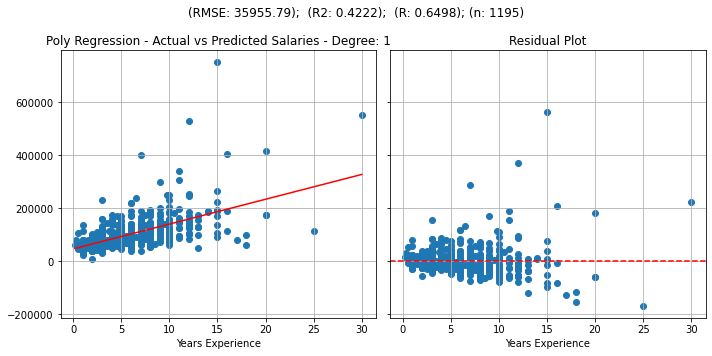

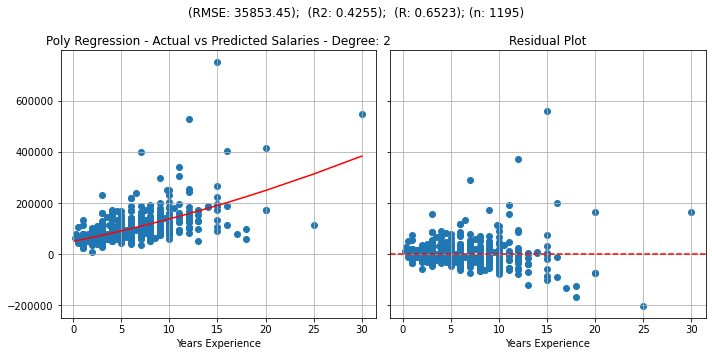

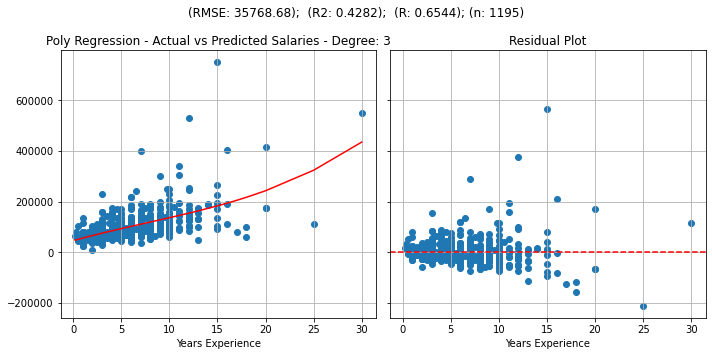

In [23]:
sample_size = us_accounting.shape[0]
rmse_list = []
r2_list = []
r_list = []
degree_list = np.arange(1, 4, 1)
for degree in degree_list:
    poly = PolynomialFeatures(degree=degree)
    X = us_accounting['Years Experience'].values.reshape(-1, 1)
    y = us_accounting['Current Salary + Bonus'].values.reshape(-1, 1)
    input_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(input_poly, y)
    preds = poly_model.predict(input_poly)
    residuals = y-preds

    rmse = np.sqrt(mean_squared_error(y, preds))
    r2 = r2_score(y, preds)
    r = np.sqrt(r2)
    rmse_list.append(rmse)
    r2_list.append(r2)
    r_list.append(r)
    
    
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10,5))
    ax[0].scatter(X, y)
    ax[0].set_title('Poly Regression - Actual vs Predicted Salaries - Degree: {}'.format(degree))
    ax[0].grid()
    ax[0].set_xlabel('Years Experience')
    ax[1].scatter(X, residuals)
    ax[1].set_title('Residual Plot')
    ax[1].set_xlabel('Years Experience')
    ax[1].grid()
    ax[1].axhline(0, color='red', linestyle='--')

    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(X, preds), key=sort_axis)
    X, preds = zip(*sorted_zip)
    ax[0].plot(X, preds, color='red')
    
    
    fig.suptitle('(RMSE: {:.2f});  (R2: {:.4f});  (R: {:.4f}); (n: {})'.format(rmse, r2, r, sample_size))
    plt.tight_layout()
    plt.show();

A degree of 1 or 2 seem to fit the data pretty well, while a third degree polynomial is starting to look more and more like overfitting.  Based on these graphs, we probably want to stick with a simple linear regression.  

Before we make our final decision, let's do a little more investigating on the tradeoff between increased complexity versus performance.

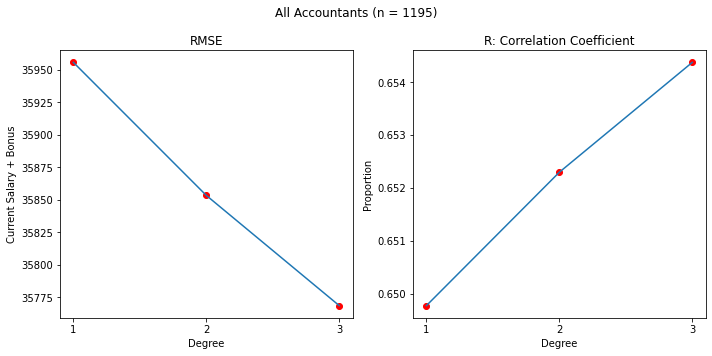

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].scatter(degree_list, rmse_list, marker='o', color='red')
ax[0].plot(degree_list, rmse_list)
ax[0].set_title('RMSE')
ax[0].set_xticks(degree_list)
ax[0].set_xlabel('Degree')
ax[0].set_ylabel('Current Salary + Bonus')

ax[1].scatter(degree_list, r_list, marker='o', color='red')
ax[1].plot(degree_list, r_list)
ax[1].set_title('R: Correlation Coefficient')
ax[1].set_xticks(degree_list)
ax[1].set_xlabel('Degree')
ax[1].set_ylabel('Proportion')

fig.suptitle('All Accountants (n = {})'.format(sample_size))
plt.tight_layout()
plt.show()

While we see a trend of lower RMSE and higher R-Values for polynomials with increasing degree, we don't see a strong enough improvement that would warrant the added complexity that a polynomial model brings.  RMSE only decreases by roughly 200 from a 1st degree model to a 3rd degree model, and the R-value only increases by about 0.04.  If we plan to stick with univariate regression, I don't think polynomial regression offers any significant advantage, while adding unneccesary complexity.  

**Conclusion: For univariate analysis, predicting `Current Salary + Bonus` is best done using `Years Experience` as the independent variable in a linear model with degree 1.  We will continue building new models and use the same baseline linear regression model from before for future comparisons**

### Multivariate Linear Regression - Predicting `Current Salary + Bonus` using more than one variable

#### Encoding certain labels and revisiting our Quantitative variables

One thing we noticed in our EDA from earlier, was that accountants with their CPA licenses tended to have higher salaries.  As such, I really want to include that variable in our multivariate regression.  This presents a problem though as there are currently 3 labels for accountants in this group: Has CPA, Doesn't Have CPA, and Finishing Experience Requirements.  

Finishing Experience Requirements is just a fancy way of saying one doesn't have their CPA license though.  As such, I'm going to consider these entries as a No and then map the No/Yes responses to a binary 0/1 variable for the regression.

In [25]:
multi_var_df = yrs_exp_without_outliers.copy(deep=True)
multi_var_df.loc[:,'Has CPA'] = multi_var_df.loc[:,'Has CPA'].map({'No':0, 'Finishing Exp Req': 0, 'Yes':1})

Let's check the correlations with a heatmap and see how helpful `Has CPA` in the regression would be.

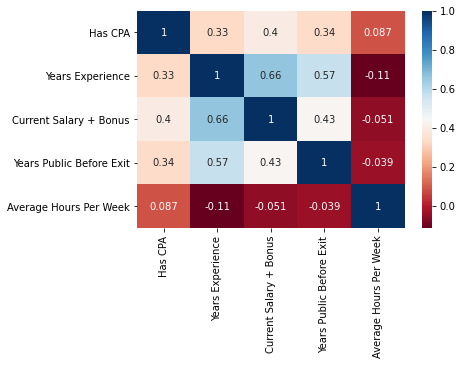

Counts for quantitative variables:
________________________________________
Has CPA                     1115.0
Years Experience            1115.0
Current Salary + Bonus      1115.0
Years Public Before Exit     181.0
Average Hours Per Week       599.0
Log Salary                  1115.0
Name: count, dtype: float64



In [26]:
sns.heatmap(multi_var_df.drop('Log Salary', axis=1).corr(), annot=True, cmap='RdBu')
plt.xticks()
plt.show()

print('Counts for quantitative variables:')
print('_' * 40)
print(multi_var_df.describe().loc['count'])
print()

`Has CPA` is looking rather reasonable with a correlation of roughly ~0.40.  The highest correlation is with `Years Experience` and next with `Years Public Before Exit`.  As discussed before, `Years Public Before Exit` doesn't apply to all accountants though and we can get similar information from `Years Experience` instead.  That being said, `Years Experience` is still looking like the best single variable to use in regression, but I'm optimistic our predictions will improve if we included `Has CPA` too.

We also noticed in the EDA that there were differences in salary based on `Gender`, which could be useful in predicting `Current Salary + Bonus`, and I'm curious if including that variable is worthwhile.  Because the entries with an undisclosed `Gender` comprises such a small percentage of the whole population (<5%), I will exclude these values and then encode the remaining entries to a binary 0/1 variable, then check correlations with a heatmap one more time.

In [28]:
multi_var_df['Gender'].value_counts(normalize=True)

Male           0.747085
Female         0.226906
Undisclosed    0.026009
Name: Gender, dtype: float64

In [29]:
multi_var_df_with_gender = multi_var_df[multi_var_df['Gender']!='Undisclosed'].copy(deep=True)
multi_var_df_with_gender.loc[:,'Gender'] = multi_var_df_with_gender.loc[:,'Gender'].map({'Female':0, 'Male':1})

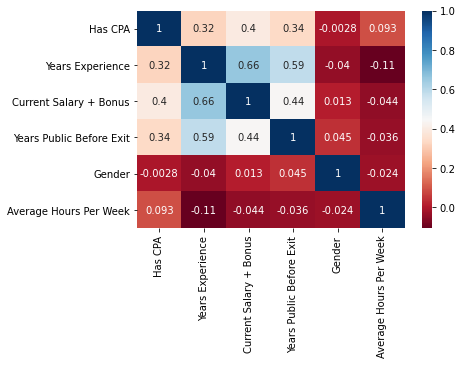

Counts for quantitative variables:
________________________________________
Has CPA                     1086.0
Years Experience            1086.0
Current Salary + Bonus      1086.0
Years Public Before Exit     177.0
Gender                      1086.0
Average Hours Per Week       588.0
Log Salary                  1086.0
Name: count, dtype: float64



In [30]:
sns.heatmap(multi_var_df_with_gender.drop('Log Salary', axis=1).corr(), annot=True, cmap='RdBu')
plt.xticks()
plt.show()

print('Counts for quantitative variables:')
print('_' * 40)
print(multi_var_df_with_gender.describe().loc['count'])
print()

Our new heatmap shows similar results to the last.  `Years Experience` and `Years Public Before Exit` have the highest correlations and `Has CPA` carries about the same correlation as before, however `Gender` has a low correlation of only about 0.01.  That being said, I don't think it's worthwhile including `Gender` in our regression and I plan to stick with `Years Experience` and `Has CPA` only.

### Multi-variate regression - Predicting `Current Salary + Bonus` using `Has CPA` and `Years Experience` - Log transformed Salaries
We will build a multiple linear regression model and compare it to our baseline to see if it yields better results that our baseline univariate regression model.

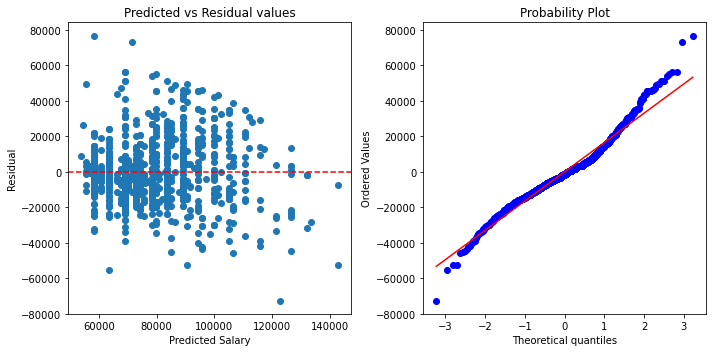

In [32]:
X = multi_var_df.loc[:, ['Has CPA', 'Years Experience']]
X = sm.add_constant(X)
y = multi_var_df.loc[:, ['Current Salary + Bonus']]

mv_linear_model = sm.OLS(y, X).fit()
preds = mv_linear_model.predict(X)
residuals = y['Current Salary + Bonus'] - preds
rmse = np.sqrt(mean_squared_error(y, preds))
r_val = np.sqrt(r2_score(y, preds))

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(preds, residuals)
ax[0].set_title('Predicted vs Residual values')
ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_xlabel('Predicted Salary')
ax[0].set_ylabel('Residual')

scipy.stats.probplot(residuals, plot=ax[1])


plt.tight_layout()
plt.show()

In [33]:
print(mv_linear_model.summary())
print()
print('Testing Data - RMSE: {:.2f}'.format(rmse))
print("Testing Data - R-Value: {:.4f}".format(r_val))

                              OLS Regression Results                              
Dep. Variable:     Current Salary + Bonus   R-squared:                       0.475
Model:                                OLS   Adj. R-squared:                  0.474
Method:                     Least Squares   F-statistic:                     502.3
Date:                    Mon, 10 May 2021   Prob (F-statistic):          3.83e-156
Time:                            18:20:51   Log-Likelihood:                -12426.
No. Observations:                    1115   AIC:                         2.486e+04
Df Residuals:                        1112   BIC:                         2.487e+04
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------


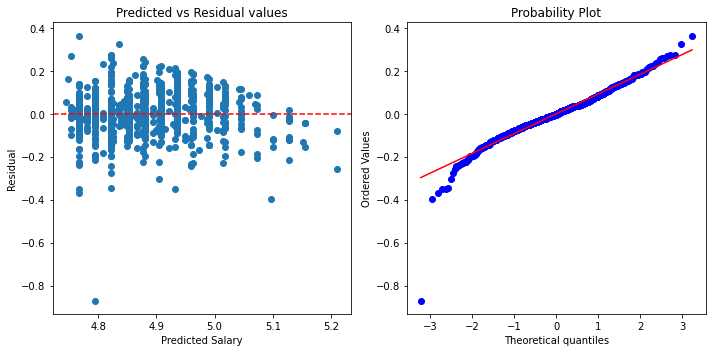

In [34]:
X = multi_var_df.loc[:, ['Has CPA', 'Years Experience']]
X = sm.add_constant(X)
y = multi_var_df.loc[:, ['Log Salary']]

mv_linear_model = sm.OLS(y, X).fit()
preds = mv_linear_model.predict(X)
residuals = y['Log Salary'] - preds
rmse = np.sqrt(mean_squared_error(10**y, 10**preds))
r_val = np.sqrt(r2_score(y, preds))

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(preds, residuals)
ax[0].set_title('Predicted vs Residual values')
ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_xlabel('Predicted Salary')
ax[0].set_ylabel('Residual')

scipy.stats.probplot(residuals, plot=ax[1])


plt.tight_layout()
plt.show()

The residual plot one again looks a little imbalanced at the very low end of predicted salaries, still with a tendency to underpredict salaries in the higher ranges, but overall not bad.  The probability plot still looks left skewed, but great everywhere else.

In [35]:
print(mv_linear_model.summary())
print()
print('Testing Data - RMSE: {:.2f}'.format(rmse))
print("Testing Data - R-Value: {:.4f}".format(r_val))

                            OLS Regression Results                            
Dep. Variable:             Log Salary   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     454.2
Date:                Mon, 10 May 2021   Prob (F-statistic):          6.40e-145
Time:                        18:20:52   Log-Likelihood:                 1052.0
No. Observations:                1115   AIC:                            -2098.
Df Residuals:                    1112   BIC:                            -2083.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.7391      0.005  

We have a respectible R-value of 0.6705 and RMSE of about 17,000.  Compared to our baseline model which used just `Years Experience` as its predictor variable, we see some improvement, the RMSE is lower by about 1,500 and the R-value is higher by a good margin.

Multiple linear regression is looking like a good model on the surface with reasonable improvement compared to our baseline model.  However, we should first verify our results with a `train_test_split` and a confidence interval.

In [36]:
y_true = y['Log Salary']
y_pred = preds
xs = X

print(get_r2(y_true, y_pred))
print(predicted_r2(y_true, y_pred, xs))

0.44962460332177034
0.4461806684167853


#### Verifying multiple regression model using `train_test_split` - Log Transformed Salaries

In [37]:
X = multi_var_df.loc[:, ['Has CPA', 'Years Experience']]
X = sm.add_constant(X)
y = multi_var_df.loc[:, ['Log Salary']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

mv_linear_model_train = sm.OLS(y_train, X_train).fit()
preds = mv_linear_model_train.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(10**y_test, 10**preds))
r_val_test = np.sqrt(r2_score(y_test, preds))

print('Testing Data - RMSE: {:.2f}'.format(rmse_test))
print("Testing Data - R-Value: {:.4f}".format(r_val_test))
print(mv_linear_model_train.summary())
print()

Testing Data - RMSE: 18870.70
Testing Data - R-Value: 0.6435
                            OLS Regression Results                            
Dep. Variable:             Log Salary   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     334.9
Date:                Mon, 10 May 2021   Prob (F-statistic):          1.32e-105
Time:                        18:20:52   Log-Likelihood:                 747.53
No. Observations:                 780   AIC:                            -1489.
Df Residuals:                     777   BIC:                            -1475.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [38]:
y_true = y_test['Log Salary']
y_pred = preds
xs = X_test
print(get_r2(y_true, y_pred))
print(predicted_r2(y_true, y_pred, xs))
print(10**np.sqrt(mv_linear_model_train.scale))
10**mv_linear_model_train.scale

0.41412736808142614
0.39995111099379754
1.2387365906262917


1.02010549777805

Using testing data to verify the model built using training data on accountants with 15 `Years Experience` or less, we get an RMSE of 19000 and R-Value of 0.6435.  These numbers indicate the train/test split generated model generalizes well to the data as it has similar a similar RMSE and R-Value compared to when we were using all of the data.

Because the train/test split was generated via a random process, we should check a confidence interval to see if this similar performance was a fluke, or if we can expect the same to happen most of the time.

#### Confidence interval for RMSE and R-Value - Log Transformed Salaries:

In [39]:
X = multi_var_df.loc[:, ['Has CPA', 'Years Experience']]
X = sm.add_constant(X)
y = multi_var_df.loc[:, ['Log Salary']]

rmse_list = []
r_val_list = []
num_trials = 1_000

for trial in np.arange(num_trials):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    trial_model = sm.OLS(y_train, X_train).fit()

    test_predictions = trial_model.predict(X_test)
    #print(test_predictions)
    test_rmse = np.sqrt(mean_squared_error(10**y_test, 10**test_predictions))
    test_r_val = np.sqrt(r2_score(y_test, test_predictions))
    
    rmse_list.append(test_rmse)
    r_val_list.append(test_r_val)

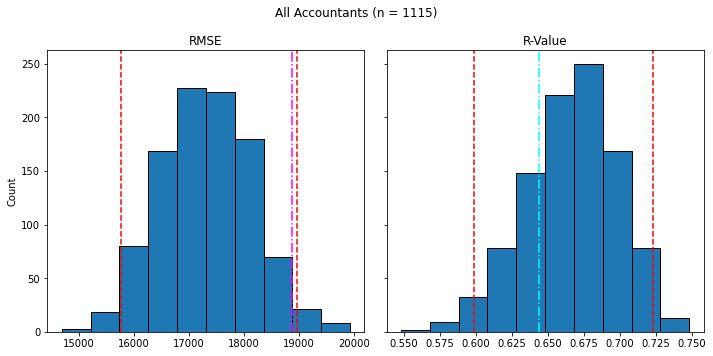

RMSE 95% Confidence Interval for 1000 trials: (15760.26, 18955.80)
R-Value 95% Confidence Interval for 1000 trials: (0.60, 0.72)


In [40]:
sample_size = multi_var_df.shape[0]

rmse_left, rmse_right = np.quantile(rmse_list, 0.025), np.quantile(rmse_list, 0.975)
r_val_left, r_val_right = np.quantile(r_val_list, 0.025), np.quantile(r_val_list, 0.975)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
ax[0].hist(rmse_list, edgecolor='black')
ax[0].set_title('RMSE')
ax[0].set_ylabel('Count')
ax[0].axvline(rmse_left, color='red', linestyle='--')
ax[0].axvline(rmse_right, color='red', linestyle='--')
ax[0].axvline(rmse_test, color='fuchsia', linestyle='-.')

ax[1].hist(r_val_list, edgecolor='black')
ax[1].set_title('R-Value')
ax[1].axvline(r_val_left, color='red', linestyle='--')
ax[1].axvline(r_val_right, color='red', linestyle='--')
ax[1].axvline(r_val_test, color='cyan', linestyle='-.')

plt.suptitle('All Accountants (n = {})'.format(sample_size))
plt.tight_layout()
plt.show();

print('RMSE 95% Confidence Interval for {} trials: ({:.2f}, {:.2f})'.format(num_trials, rmse_left, rmse_right))
print('R-Value 95% Confidence Interval for {} trials: ({:.2f}, {:.2f})'.format(num_trials, r_val_left, r_val_right))

Interestingly enough, the RMSE of 19,000 is just barely inside our 95% confidence interval, but the confidence interval of 16,000 to 19,000 is almost identical to the confidence interval for RMSE of our baseline linear regression model.  

The R-value of 0.64 is a typical value, the confidence interval of 0.60 to 0.72 is much narrower compared to the confidence interval of our baseline and there is less variability in the strength of the association between the independent and dependent variables with this multiple regression model as a result.

**Conclusion: Multiple Regression using `Years Experience` and `Has CPA` as predictor variables appears to better at predicting `Current Salary + Bonus` that our baseline regression model.  The added complexity is probably worth the increased performance, as long as the cost of implementing this one over our baseline is minimal.  I would assume that obtaining information on whether an accountant has their CPA license should be more straightforward than getting their salary information and the added cost would be minimal.  Therefore, I will consider this my new baseline model for future comparisons.**

### Multi-variate regression - Involving categorical variables

Up until now we've mainly examined quantitative data and our most recent model only has two input variables, but what happens if we use all of our data in our predictions and begin to include more of our categorical data?  

##### **Pre-Processing**
In order to get the categorical data ready, we have to do some pre-processing:
1. Feature Scaling
2. Encoding

We begin with scaling our numerical data using `StandardScaler` and encoding our remaining categorical data into dummy variables, dropping the first column for each dummy variable during the process.

In [56]:
us_accounting_scaled = multi_var_df.copy(deep=True)
us_accounting_scaled.drop('Log Salary', axis=1, inplace=True)
numeric_cols = us_accounting_scaled.select_dtypes(include=[float, int])
numeric_cols = numeric_cols.drop(['Has CPA'], axis=1)
numeric_cols_labels = numeric_cols.columns

categorical_cols = us_accounting_scaled.select_dtypes(include=object)
categorical_cols_labels = list(categorical_cols.columns)


scaler = StandardScaler()
scaler.fit(numeric_cols)
us_accounting_scaled.loc[:, numeric_cols_labels] = scaler.transform(numeric_cols)


scaled_with_dummies = pd.get_dummies(us_accounting_scaled, columns=categorical_cols_labels, drop_first=True)

Now that our data is processed, we'll split it into two dataframes, one containing the independent variables and the other containing the dependent variable.

In [43]:
training_input_labels = list(scaled_with_dummies.columns)
training_input_labels.remove('Current Salary + Bonus')
training_df = scaled_with_dummies.loc[:, training_input_labels]
target_df = scaled_with_dummies.loc[:, 'Current Salary + Bonus']

Because we are working with so many variables, we may start running into collinear features that will negatively impact any model we build.  To detect these features, we can use something called Variance Inflation Factor (VIF), where a VIF of 5-10 or more indicates that some of the independent variables are actually dependent on each other.  Before we create any new models, we will use a helper function called `calc_vif` to systematically remove features with a VIF of higher than 5, unfortunately we can't include features with NaN values when using this function to calculate VIF.

We know from earlier that `Years Public Before Exit` restricted our analysis because of the large number of NaN values and `Years Experience` was a better choice as a predictor variable anyways.  Furthermore, `Average Hours Per week` didn't seem highly correlated with any of the other variables earlier and had a significant number of NaN values too.  For all of these reasons, I'm going to drop these two columns and proceed to check VIF from there.

In [44]:
training_df.drop(labels=['Years Public Before Exit', 'Average Hours Per Week'], axis=1, inplace=True)

In [45]:
bad_training_labels = []
bad_vifs = []
flag = True
loop_df = training_df.copy(deep=True)
while flag == True:
    vif_df = calc_vif(loop_df)
    vif_df_sorted = vif_df.sort_values('VIF', ascending=False)
    top_vif = vif_df_sorted.iloc[0,1]
    top_vif_rounded = round(top_vif, 3)
    if top_vif <= 5:
        flag = False
        final_df = vif_df
    else:
        bad_label = vif_df_sorted.iloc[0,0]
        #bad_vifs = vif_df_sorted.iloc[0,1]
        bad_training_labels.append(bad_label)
        bad_vifs.append(top_vif)
        loop_df.drop(labels=bad_label, axis=1, inplace=True)  
bad_training_labels
bad_vifs_df = pd.DataFrame(data=bad_vifs, index=bad_training_labels, columns=['VIF'])
bad_vifs_df

,VIF
Exit Status_I have never worked at a public accounting firm,17.751887
Current Industry_Public Accounting,10.346925


Looks like both of these variables had a high VIF, let's remove them from the training_df and then check the VIFs that remain.

In [46]:
training_df.drop(labels=[label for label in bad_vifs_df.index.values], axis=1, inplace=True)
calc_vif(training_df).sort_values('VIF', ascending=False)

,Variables,VIF
19,Gender_Male,3.512615
21,Line of Service_Audit,3.326030
24,Line of Service_Other,3.218662
25,Line of Service_Tax,2.556878
14,Current Industry_Other,2.551029
5,Exit Status_I have already exited from a mid-t...,2.369495
0,Has CPA,2.262529
2,Exit Status_I am currently working at a mid-ti...,2.235927
4,Exit Status_I have already exited from a Big 4...,2.194497
18,What COL is your region?_Medium,2.140301


Afterwards, all of our VIFS are 3.5 or less.  

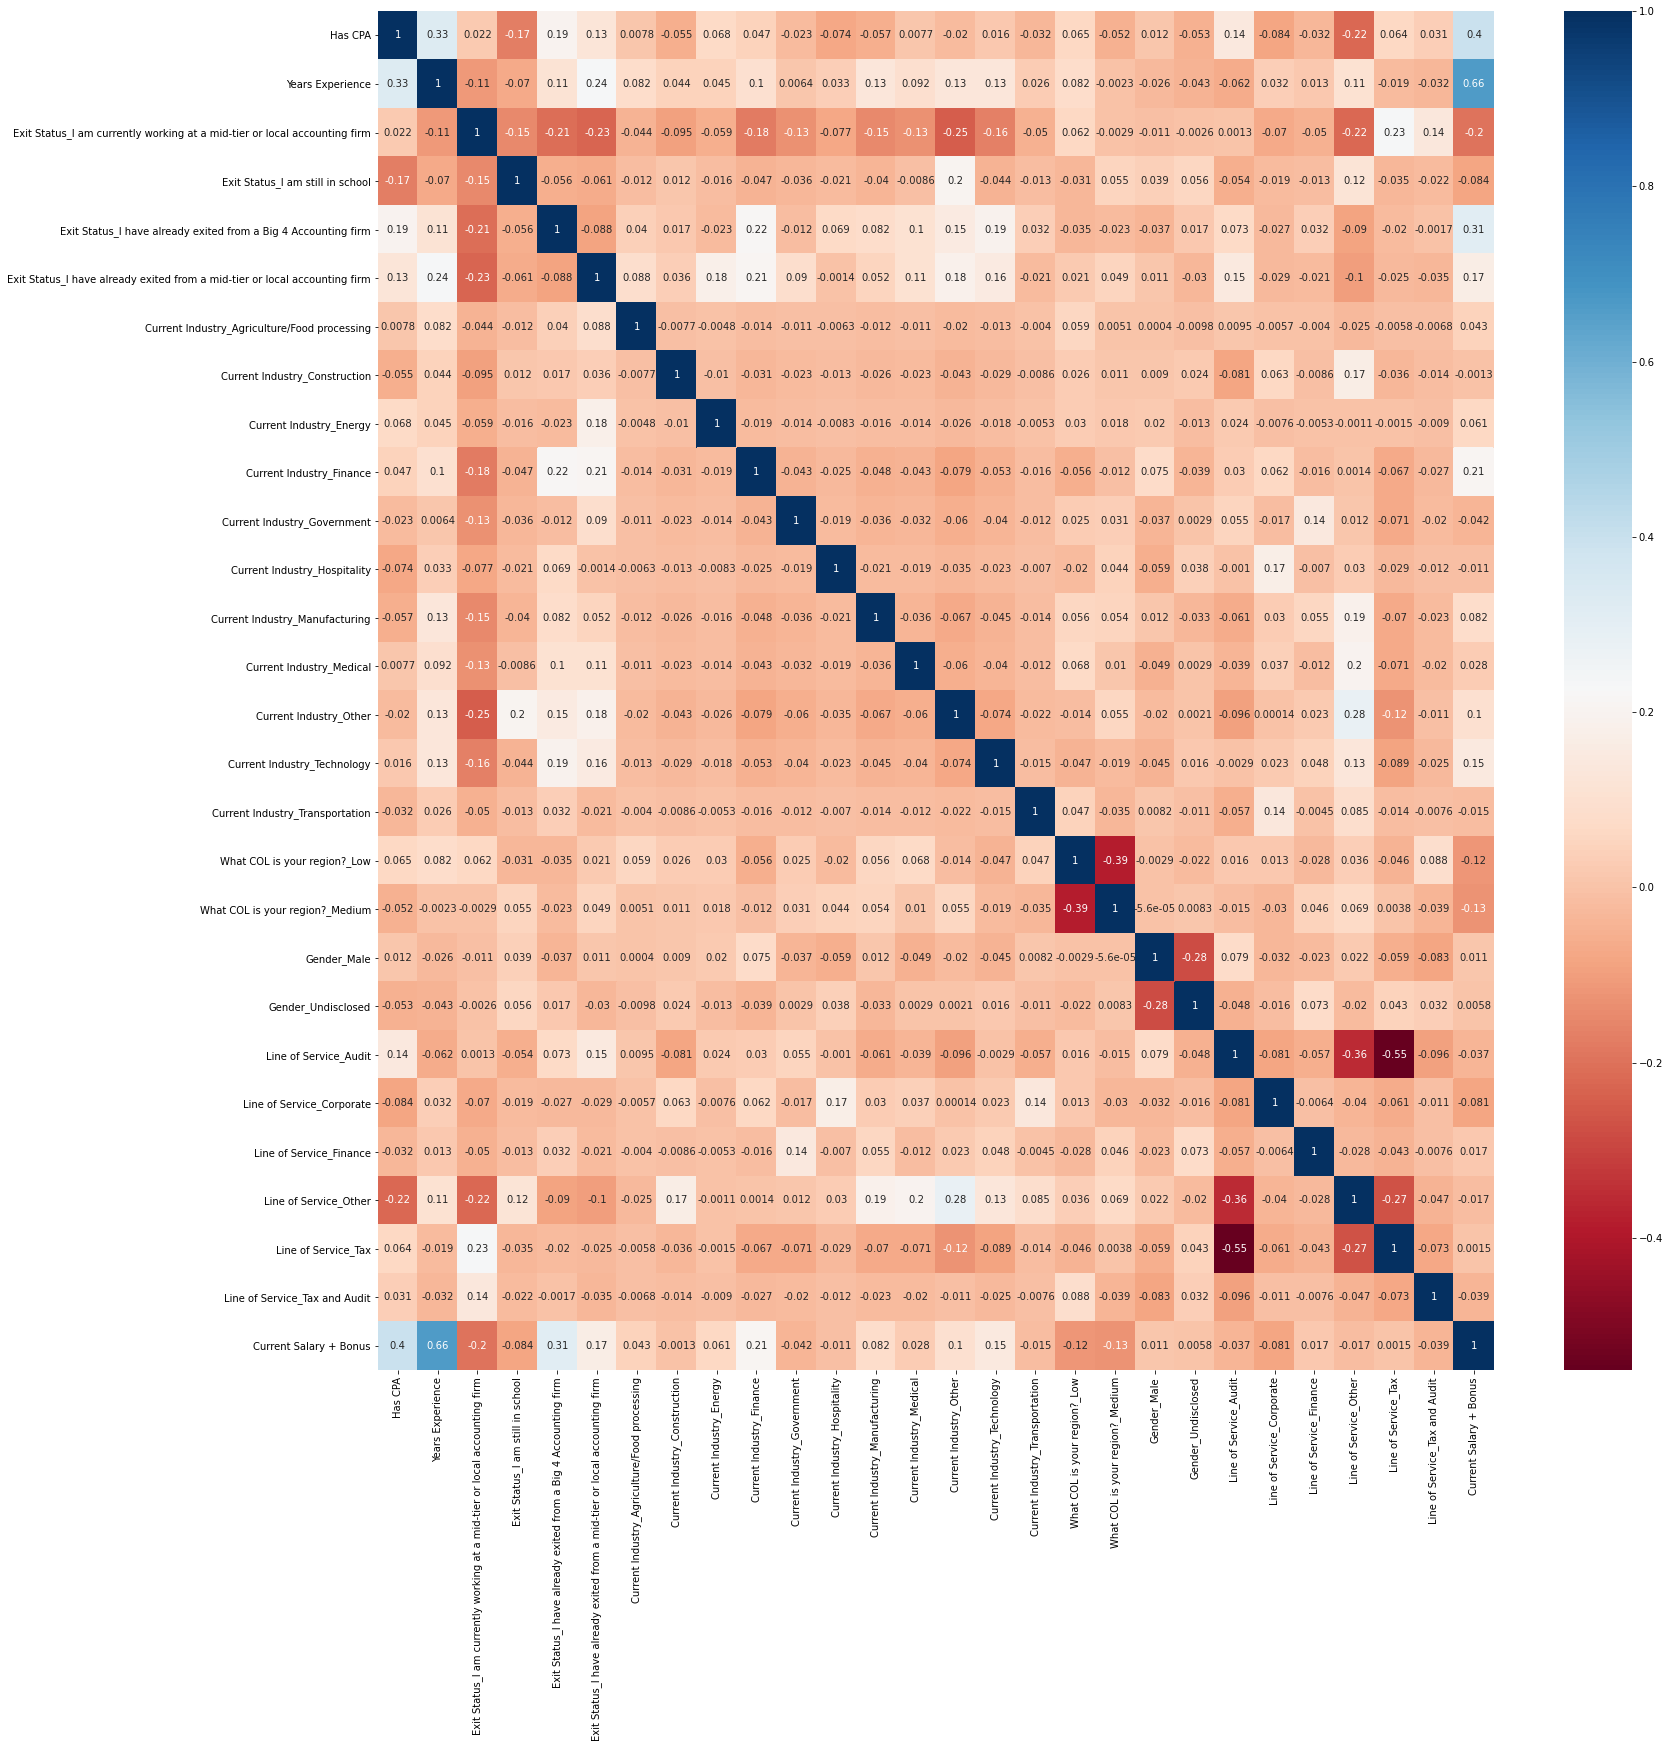

In [47]:
temp = pd.concat([training_df, target_df], axis=1)
plt.figure(figsize=(25,25))
sns.heatmap(temp.corr(), cmap='RdBu', annot=True)
plt.show()

Our heatmap shows the strongest positive correlations (>0.3) as:
1. Has CPA (0.3970)
2. Years Experience (0.6607)
3. Exit Status_I have already exited from a Big 4 Accounting firm (0.3128)

The strongest negative correlations is Exit Status_I am currently working at a mid-tier or local accounting firm at -0.1970.

Has CPA and Years Experience still look to be the best features to use by far and many of our other variables seem rather insignificant.

### Multivariate regression - Using all the variables
For starters, let's build a model using all of the features and see how well it performs, then re-evaluate.

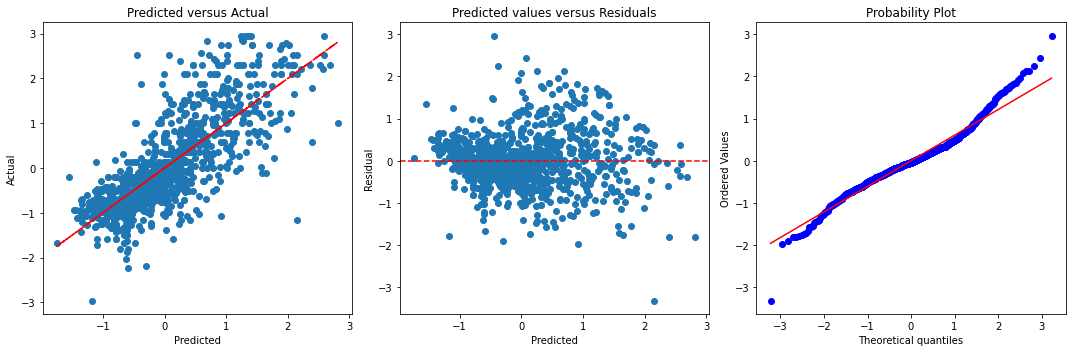

In [48]:
X = sm.add_constant(training_df)
y = target_df

mv_linear_model_all = sm.OLS(y, X).fit()
preds = mv_linear_model_all.predict(X)
residuals = y - preds

scaled_mu = multi_var_df['Current Salary + Bonus'].mean()
scaled_sigma = multi_var_df['Current Salary + Bonus'].std()
regular_y = scaled_sigma * y + scaled_mu
regular_preds = scaled_sigma * preds + scaled_mu
regular_residuals = scaled_sigma * residuals + scaled_mu

rmse = np.sqrt(mean_squared_error(regular_y, regular_preds))
r_val = np.sqrt(r2_score(regular_y, regular_preds))

fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].scatter(preds, y)
ax[0].plot(preds, preds, color='red', linestyle='-.')
ax[0].set_title('Predicted versus Actual')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].scatter(preds, residuals)
ax[1].set_title('Predicted values versus Residuals')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Residual')
ax[1].axhline(0, color='red', linestyle='--')

scipy.stats.probplot(residuals, plot=ax[2])

plt.tight_layout()
plt.show()

In our first plot, we can see that the actual versus predicted values follow our diagonal line pretty well, indicating a linear trend in the data and our linear model is appropriate.  

Furthermore, the second plot shows a tendency to overestimate salaries in the very low end and underpredict them on the very high end, something we noticed before with our previous models.  Overall though, the scatter plot doesn't follow any systematic pattern and I think it's good enough for our purposes.  More evidence that linear regression is appropriate.

Lastly, the probability plot indicates our error terms are skewed right and not normally distributed, violating one of the assumptions needed for linear regression, but the probability plot is close enough and I plan to continue for now.  

In [49]:
print(mv_linear_model_all.summary())
print()
print('RMSE: {:.2f}'.format(rmse))
print("R-Value: {:.4f}".format(r_val))

                              OLS Regression Results                              
Dep. Variable:     Current Salary + Bonus   R-squared:                       0.620
Model:                                OLS   Adj. R-squared:                  0.611
Method:                     Least Squares   F-statistic:                     65.82
Date:                    Mon, 10 May 2021   Prob (F-statistic):          5.62e-207
Time:                            18:21:03   Log-Likelihood:                -1042.0
No. Observations:                    1115   AIC:                             2140.
Df Residuals:                        1087   BIC:                             2280.
Df Model:                              27                                         
Covariance Type:                nonrobust                                         
                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

The model has great performance with RMSE of ~14,000 and R-Value of 0.7877, by far the best performance yet, but it's incredibly complex with 27 features.  I'm going to cut out the independent variables that were not considered statistically significant at the 5% level of significance, according to the t-tests in the OLS summary above, then create a new model.

### Multivariate regression - using only statistically significant features
First we'll indentify which independent variables are statistically significant, then create a new model and analyze the residuals and performance.

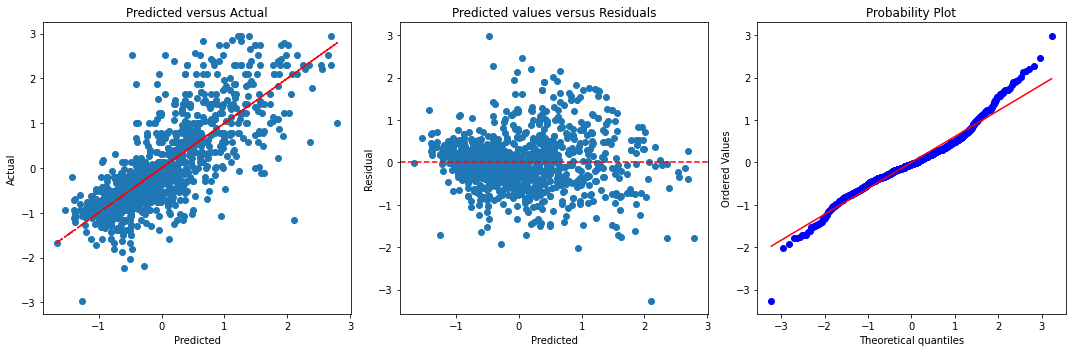

In [50]:
stat_sig_features = list(mv_linear_model_all.params[mv_linear_model_all.pvalues<0.05].index)
stat_sig_features.remove('const')
stat_sig_features

X = training_df.loc[:, stat_sig_features]
X = sm.add_constant(X)
y = target_df

mv_stat_sig_model = sm.OLS(y, X).fit()
preds = mv_stat_sig_model.predict(X)
residuals = y - preds

scaled_mu = multi_var_df['Current Salary + Bonus'].mean()
scaled_sigma = multi_var_df['Current Salary + Bonus'].std()
regular_y = scaled_sigma * y + scaled_mu
regular_preds = scaled_sigma * preds + scaled_mu
regular_residuals = scaled_sigma * residuals + scaled_mu

rmse = np.sqrt(mean_squared_error(regular_y, regular_preds))
r_val = np.sqrt(r2_score(regular_y, regular_preds))

fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].scatter(preds, y)
ax[0].plot(preds, preds, color='red', linestyle='-.')
ax[0].set_title('Predicted versus Actual')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].scatter(preds, residuals)
ax[1].set_title('Predicted values versus Residuals')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Residual')
ax[1].axhline(0, color='red', linestyle='--')

scipy.stats.probplot(residuals, plot=ax[2])

plt.tight_layout()
plt.show()

All of these plots look virtually identical to the ones from above, however we're done to just 12 features now.  Let's check the performance.

In [51]:
print(mv_stat_sig_model.summary())
print()
print('RMSE: {:.2f}'.format(rmse))
print("R-Value: {:.4f}".format(r_val))

                              OLS Regression Results                              
Dep. Variable:     Current Salary + Bonus   R-squared:                       0.614
Model:                                OLS   Adj. R-squared:                  0.610
Method:                     Least Squares   F-statistic:                     146.2
Date:                    Mon, 10 May 2021   Prob (F-statistic):          4.57e-218
Time:                            18:21:04   Log-Likelihood:                -1051.1
No. Observations:                    1115   AIC:                             2128.
Df Residuals:                        1102   BIC:                             2193.
Df Model:                              12                                         
Covariance Type:                nonrobust                                         
                                                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

We see about the same performance as before, but the model is still fairly complex.  We could reduce the complexity further and probably maintain similar performance by removing any independent variables that are now considered to be statistically insignificant.  Let's do that and re-evaluate.

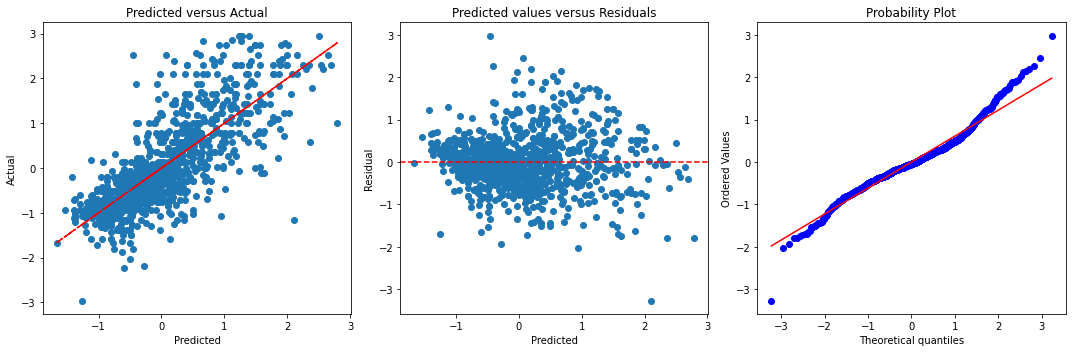

In [52]:
stat_sig_features = list(mv_stat_sig_model.params[mv_stat_sig_model.pvalues<0.05].index)
stat_sig_features.remove('const')
stat_sig_features

X = training_df.loc[:, stat_sig_features]
X = sm.add_constant(X)
y = target_df

mv_stat_sig_model2 = sm.OLS(y, X).fit()
preds = mv_stat_sig_model2.predict(X)
residuals = y - preds

scaled_mu = multi_var_df['Current Salary + Bonus'].mean()
scaled_sigma = multi_var_df['Current Salary + Bonus'].std()
regular_y = scaled_sigma * y + scaled_mu
regular_preds = scaled_sigma * preds + scaled_mu
regular_residuals = scaled_sigma * residuals + scaled_mu

rmse = np.sqrt(mean_squared_error(regular_y, regular_preds))
r_val = np.sqrt(r2_score(regular_y, regular_preds))

fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].scatter(preds, y)
ax[0].plot(preds, preds, color='red', linestyle='-.')
ax[0].set_title('Predicted versus Actual')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].scatter(preds, residuals)
ax[1].set_title('Predicted values versus Residuals')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Residual')
ax[1].axhline(0, color='red', linestyle='--')

scipy.stats.probplot(residuals, plot=ax[2])

plt.tight_layout()
plt.show()

Similar plots to before.

In [53]:
print(mv_stat_sig_model2.summary())
print()
print('RMSE: {:.2f}'.format(rmse))
print("R-Value: {:.4f}".format(r_val))

                              OLS Regression Results                              
Dep. Variable:     Current Salary + Bonus   R-squared:                       0.613
Model:                                OLS   Adj. R-squared:                  0.609
Method:                     Least Squares   F-statistic:                     159.0
Date:                    Mon, 10 May 2021   Prob (F-statistic):          1.33e-218
Time:                            18:21:04   Log-Likelihood:                -1052.5
No. Observations:                    1115   AIC:                             2129.
Df Residuals:                        1103   BIC:                             2189.
Df Model:                              11                                         
Covariance Type:                nonrobust                                         
                                                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

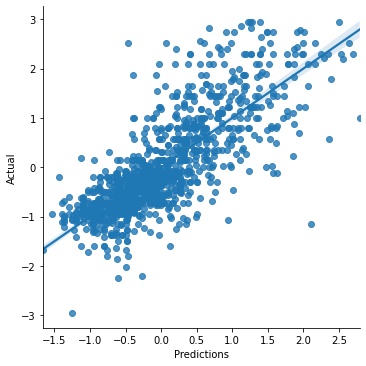

In [54]:
temp_df = pd.DataFrame({'Predictions': preds, 'Actual':y, 'Residuals':residuals})
sns.lmplot(x='Predictions', y='Actual', data=temp_df)

Similar performance, but down to 11 variables now, all of which are statistically significant at a 5% level of significance.  The model still seems too complex and I'd like to work on getting the error terms to look more normal before going further, but I'm going to stop for now.  

Perhaps making a model that can predict salaries all the way up to 15 years was too optimistic and a model going up to 10 years would be more appropriate instead.  It may deal with the issues with our residuals in the right tail and if the model isn't going to be used by accountants in the 10-15 years experience range, it wouldn't be relevant keeping those observations anyways.

Additionally, futher investigation should be done in salaries with less than 1 years experience as we also noticed some issues with our residuals in the left tail.

**Conclusion: Until more work on this model can be done, the Multivariate linear regression from earlier that used only `Has CPA` and `Years Experience` to predict `Current Salary + Bonus` remains the best model so far.  It has great performance, minimal complexity, and is very close to satisfying all of the assumptions needed for linear regression.**